In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.gridspec import GridSpec

Generación de puntos 3d

In [10]:
def a_homogeneas(puntos):
    n = puntos.shape[1]
    return np.vstack((puntos, np.ones((1, n))))


def de_homogeneas(puntos_hom):
    w = puntos_hom[-1, :]
    return puntos_hom[:-1, :] / w

def generar_cubo(escala=1.0, offset=(0, 0, 3)):
    ox, oy, oz = offset
    s = escala
    vertices = np.array([
        # x,  y,  z
        [-s, -s, -s],
        [ s, -s, -s],
        [ s,  s, -s],
        [-s,  s, -s],
        [-s, -s,  s],
        [ s, -s,  s],
        [ s,  s,  s],
        [-s,  s,  s],
    ], dtype=float).T  # (3, 8)

    vertices[0] += ox
    vertices[1] += oy
    vertices[2] += oz

    aristas = [
        (0,1),(1,2),(2,3),(3,0),   # cara trasera
        (4,5),(5,6),(6,7),(7,4),   # cara delantera
        (0,4),(1,5),(2,6),(3,7),   # laterales
    ]
    return vertices, aristas


# Demo: mostrar representación homogénea
verts_cubo, aristas_cubo = generar_cubo(escala=1.0, offset=(0, 0, 4))
verts_hom   = a_homogeneas(verts_cubo)
print('Vértices del cubo (3D cartesianas) — shape:', verts_cubo.shape)
print(np.round(verts_cubo, 2))
print()
print('Vértices en coordenadas HOMOGÉNEAS (4D) — shape:', verts_hom.shape)
print(np.round(verts_hom, 2))

Vértices del cubo (3D cartesianas) — shape: (3, 8)
[[-1.  1.  1. -1. -1.  1.  1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1.]
 [ 3.  3.  3.  3.  5.  5.  5.  5.]]

Vértices en coordenadas HOMOGÉNEAS (4D) — shape: (4, 8)
[[-1.  1.  1. -1. -1.  1.  1. -1.]
 [-1. -1.  1.  1. -1. -1.  1.  1.]
 [ 3.  3.  3.  3.  5.  5.  5.  5.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]]


Proyección ortogonal

In [11]:
def matriz_ortogonal():
    P = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1]
    ], dtype=float)
    return P

def matriz_perspectiva(d=1.0):
    P = np.array([
        [1, 0,   0,   0],
        [0, 1,   0,   0],
        [0, 0,   1,   0],
        [0, 0, 1/d,   0]
    ], dtype=float)
    return P

def proyectar_perspectiva(puntos, d=1.0):
    P = matriz_perspectiva(d)
    puntos_hom = a_homogeneas(puntos)         # (4, N)
    proy = P @ puntos_hom                     # (4, N)
    proy = proy / proy[-1, :]                 # dividir por w
    return proy[:2, :]                        # tomar solo x, y

def proyectar_ortogonal(puntos):
    P = matriz_ortogonal()
    puntos_hom = a_homogeneas(puntos)         # (4, N)
    proy = P @ puntos_hom                     # (4, N)
    return proy[:2, :]                        # tomar solo x, y

print('=' * 50)
print('  MATRIZ DE PROYECCIÓN ORTOGONAL')
print('=' * 50)
print(matriz_ortogonal())

print()
print('=' * 50)
print('  MATRIZ DE PROYECCIÓN PERSPECTIVA (d=1.5)')
print('=' * 50)
print(np.round(matriz_perspectiva(d=1.5), 4))

  MATRIZ DE PROYECCIÓN ORTOGONAL
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

  MATRIZ DE PROYECCIÓN PERSPECTIVA (d=1.5)
[[1.     0.     0.     0.    ]
 [0.     1.     0.     0.    ]
 [0.     0.     1.     0.    ]
 [0.     0.     0.6667 0.    ]]


Proyección de perspectiva


/tmp/ipython-input-161/1334891229.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


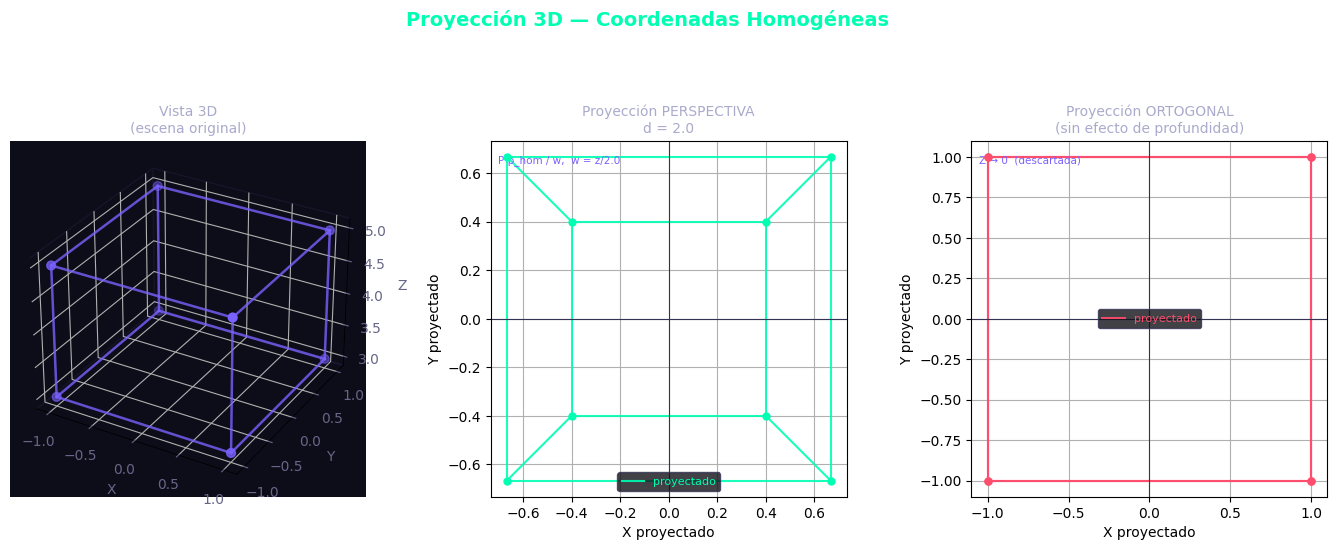

✅ Gráfico guardado: proyeccion_comparacion.png


In [12]:
def dibujar_aristas_2d(ax, puntos_2d, aristas, color, lw=1.5, alpha=0.9, label=None):
    """Dibuja aristas de un objeto en un eje 2D."""
    primer = True
    for i, (a, b) in enumerate(aristas):
        lbl = label if (primer and label) else None
        ax.plot(
            [puntos_2d[0, a], puntos_2d[0, b]],
            [puntos_2d[1, a], puntos_2d[1, b]],
            color=color, lw=lw, alpha=alpha, label=lbl
        )
        primer = False
    ax.scatter(puntos_2d[0], puntos_2d[1], color=color, s=25, zorder=5)


def dibujar_aristas_3d(ax, puntos_3d, aristas, color, lw=1.5, alpha=0.8):
    """Dibuja aristas de un objeto en un eje 3D."""
    for a, b in aristas:
        ax.plot3D(
            [puntos_3d[0, a], puntos_3d[0, b]],
            [puntos_3d[1, a], puntos_3d[1, b]],
            [puntos_3d[2, a], puntos_3d[2, b]],
            color=color, lw=lw, alpha=alpha
        )

d_focal = 2.0
verts, aristas = generar_cubo(escala=1.0, offset=(0, 0, 4))

# Proyecciones
proy_persp = proyectar_perspectiva(verts, d=d_focal)
proy_ortog = proyectar_ortogonal(verts)

fig = plt.figure(figsize=(17, 6))
fig.suptitle(
    'Proyección 3D — Coordenadas Homogéneas',
    fontsize=14, fontweight='bold', color='#00ffb3', y=1.01
)

gs = GridSpec(1, 3, figure=fig, wspace=0.35)

ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.set_facecolor('#0d0d1a')
dibujar_aristas_3d(ax1, verts, aristas, color='#7b61ff', lw=1.8)
ax1.scatter3D(verts[0], verts[1], verts[2], color='#7b61ff', s=40, zorder=5)
ax1.set_title('Vista 3D\n(escena original)', color='#aaaacc', fontsize=10)
ax1.set_xlabel('X', color='#666688'); ax1.set_ylabel('Y', color='#666688'); ax1.set_zlabel('Z', color='#666688')
ax1.tick_params(colors='#666688')
ax1.xaxis.pane.fill = False; ax1.yaxis.pane.fill = False; ax1.zaxis.pane.fill = False
ax1.xaxis.pane.set_edgecolor('#1e1e3a')
ax1.yaxis.pane.set_edgecolor('#1e1e3a')
ax1.zaxis.pane.set_edgecolor('#1e1e3a')

ax2 = fig.add_subplot(gs[1])
dibujar_aristas_2d(ax2, proy_persp, aristas, color='#00ffb3', label='proyectado')
ax2.axhline(0, color='#333355', lw=0.8)
ax2.axvline(0, color='#333355', lw=0.8)
ax2.set_title(f'Proyección PERSPECTIVA\nd = {d_focal}', color='#aaaacc', fontsize=10)
ax2.set_xlabel('X proyectado'); ax2.set_ylabel('Y proyectado')
ax2.grid(True); ax2.set_aspect('equal')
ax2.legend(fontsize=8, facecolor='#111118', labelcolor='#00ffb3', edgecolor='#333355')
# Anotar fórmula
ax2.text(0.02, 0.96, f"P·p_hom / w,  w = z/{d_focal}",
         transform=ax2.transAxes, fontsize=7.5, color='#7b61ff', va='top')

ax3 = fig.add_subplot(gs[2])
dibujar_aristas_2d(ax3, proy_ortog, aristas, color='#ff4d6d', label='proyectado')
ax3.axhline(0, color='#333355', lw=0.8)
ax3.axvline(0, color='#333355', lw=0.8)
ax3.set_title('Proyección ORTOGONAL\n(sin efecto de profundidad)', color='#aaaacc', fontsize=10)
ax3.set_xlabel('X proyectado'); ax3.set_ylabel('Y proyectado')
ax3.grid(True); ax3.set_aspect('equal')
ax3.legend(fontsize=8, facecolor='#111118', labelcolor='#ff4d6d', edgecolor='#333355')
ax3.text(0.02, 0.96, "Z → 0  (descartada)",
         transform=ax3.transAxes, fontsize=7.5, color='#7b61ff', va='top')

plt.tight_layout()
plt.savefig('proyeccion_comparacion.png', dpi=150, bbox_inches='tight', facecolor='#0d0d1a')
plt.show()
print('Gráfico guardado: proyeccion_comparacion.png')

Visualización

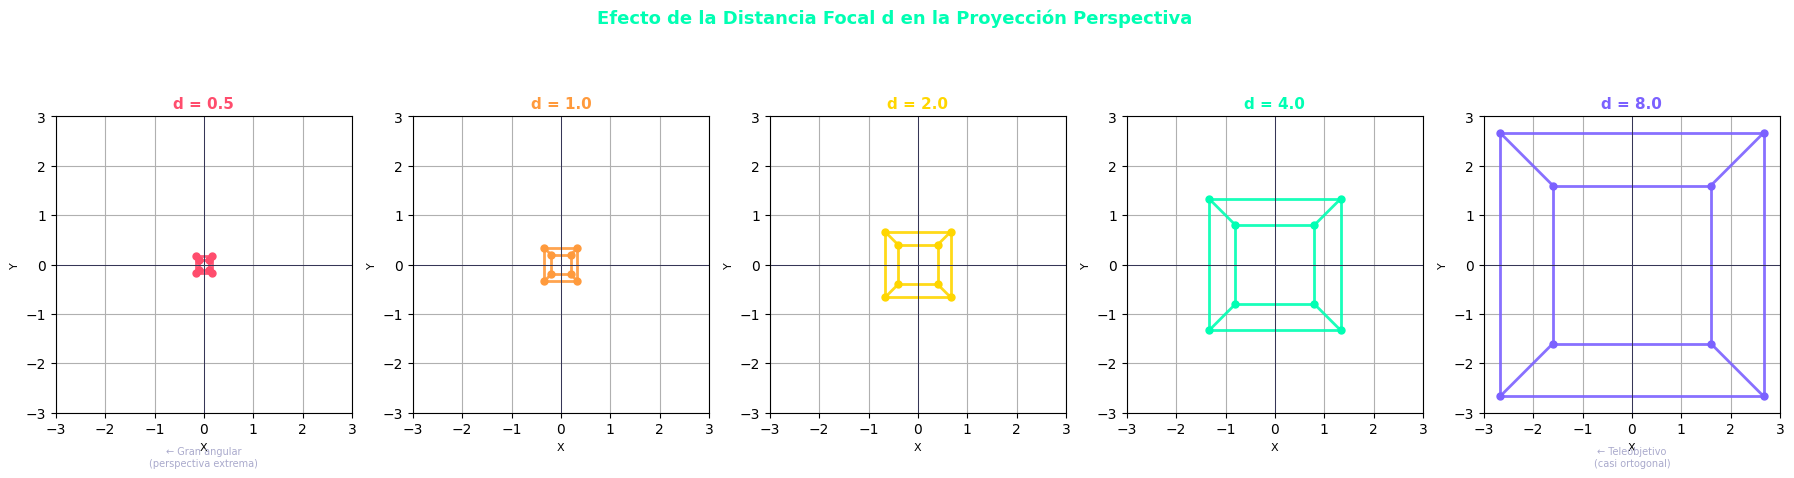

✅ Gráfico guardado: efecto_focal.png


In [13]:
distancias_focales = [0.5, 1.0, 2.0, 4.0, 8.0]
colores_d          = ['#ff4d6d', '#ff9a3c', '#ffd600', '#00ffb3', '#7b61ff']

verts, aristas = generar_cubo(escala=1.0, offset=(0, 0, 4))

fig, axes = plt.subplots(1, len(distancias_focales), figsize=(18, 4.5))
fig.suptitle(
    'Efecto de la Distancia Focal d en la Proyección Perspectiva',
    fontsize=13, fontweight='bold', color='#00ffb3', y=1.03
)

for ax, d, color in zip(axes, distancias_focales, colores_d):
    proy = proyectar_perspectiva(verts, d=d)
    dibujar_aristas_2d(ax, proy, aristas, color=color, lw=2.0)
    ax.axhline(0, color='#333355', lw=0.7)
    ax.axvline(0, color='#333355', lw=0.7)
    ax.set_title(f'd = {d}', color=color, fontsize=11, fontweight='bold')
    ax.set_xlabel('X', fontsize=8); ax.set_ylabel('Y', fontsize=8)
    ax.grid(True)
    ax.set_aspect('equal')
    ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)

    # Etiqueta de interpretación
    if d <= 0.5:
        etiqueta = '← Gran angular\n(perspectiva extrema)'
    elif d >= 8.0:
        etiqueta = '← Teleobjetivo\n(casi ortogonal)'
    else:
        etiqueta = ''
    if etiqueta:
        ax.text(0.5, -0.18, etiqueta, transform=ax.transAxes,
                fontsize=7, color='#aaaacc', ha='center')

plt.tight_layout()
plt.savefig('efecto_focal.png', dpi=150, bbox_inches='tight', facecolor='#0d0d1a')
plt.show()

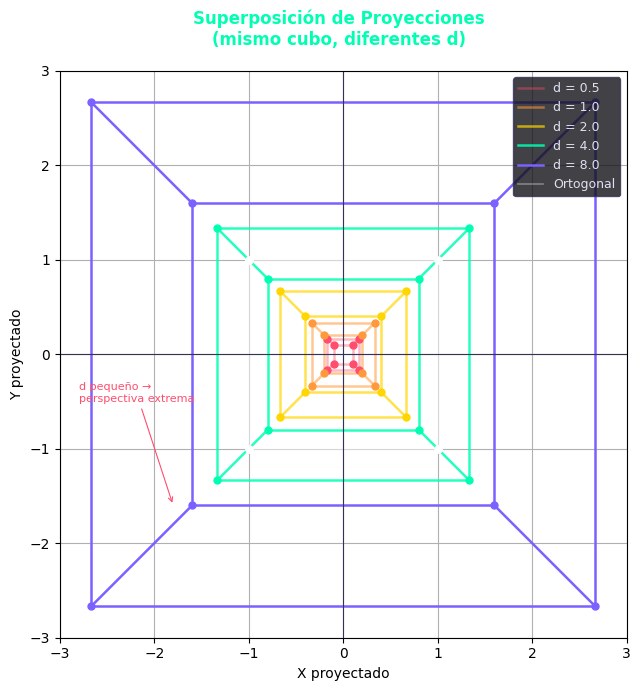

In [15]:
fig, ax = plt.subplots(figsize=(8, 7))
fig.suptitle('Superposición de Proyecciones\n(mismo cubo, diferentes d)',
             color='#00ffb3', fontsize=12, fontweight='bold')

alphas = [0.4, 0.55, 0.7, 0.85, 1.0]

for d, color, alpha in zip(distancias_focales, colores_d, alphas):
    proy = proyectar_perspectiva(verts, d=d)
    dibujar_aristas_2d(ax, proy, aristas, color=color, alpha=alpha,
                       label=f'd = {d}', lw=1.8)

# Ortogonal encima para comparar
proy_o = proyectar_ortogonal(verts)
dibujar_aristas_2d(ax, proy_o, aristas, color='white', alpha=0.35,
                   label='Ortogonal', lw=1.2)

ax.axhline(0, color='#333355', lw=0.8)
ax.axvline(0, color='#333355', lw=0.8)
ax.set_xlabel('X proyectado'); ax.set_ylabel('Y proyectado')
ax.grid(True); ax.set_aspect('equal')
ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)
ax.legend(fontsize=9, facecolor='#111118', edgecolor='#333355',
          labelcolor='#e0e0f0', loc='upper right')

# Anotación
ax.annotate('d pequeño → \nperspectiva extrema',
            xy=(-1.8, -1.6), fontsize=8, color='#ff4d6d',
            arrowprops=dict(arrowstyle='->', color='#ff4d6d', lw=0.8),
            xytext=(-2.8, -0.5))

plt.tight_layout()
plt.savefig('superposicion_focal.png', dpi=150, bbox_inches='tight', facecolor='#0d0d1a')
plt.show()